# [1주차] 심화 과제: MNIST 예측 모델에 deep learning techniques 적용하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.optim import SGD, Adam

import numpy as np

from matplotlib import pyplot as plt

In [2]:
transform = transforms.ToTensor()

batch_size = 256

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12881528.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


50000
torch.Size([3, 32, 32]) 6


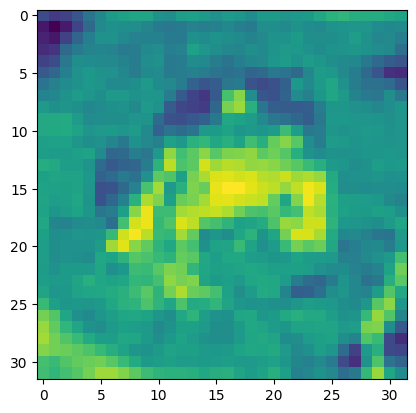

In [4]:
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0])

In [5]:
dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


10000
torch.Size([3, 32, 32]) 3


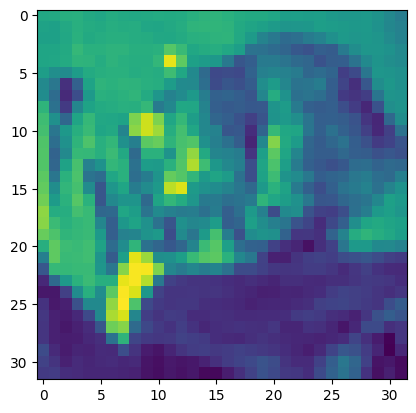

In [6]:
print(len(testset))
print(testset[0][0].shape, testset[0][1])
plt.imshow(testset[0][0][0])

## (Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot

### Adam으로 학습

In [7]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    ## 활성화 함수: LeakyReLU
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [14]:
input_dim = 32 * 32 * 3
n_dim = 1024
lr = 0.001
n_epochs = 30

model = model = Model(input_dim, n_dim).to('cuda')

optimizer = Adam(model.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss()

In [16]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [17]:
train_accs_adam = []
test_accs_adam = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    ## CrossEntropy 정의
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # 1 epoch 당 정확도 저장
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  train_accs_adam.append(train_acc)
  test_accs_adam.append(test_acc)

  print(f"Epoch {epoch+1} | Loss: {total_loss} | Train Acc: {train_acc} | Test Acc: {test_acc}")

Epoch 1 | Loss: 401.7527139186859 | Train Acc: 0.2555 | Test Acc: 0.2528
Epoch 2 | Loss: 379.5317665338516 | Train Acc: 0.30924 | Test Acc: 0.3082
Epoch 3 | Loss: 362.70227324962616 | Train Acc: 0.34154 | Test Acc: 0.3382
Epoch 4 | Loss: 350.7021554708481 | Train Acc: 0.37402 | Test Acc: 0.3729
Epoch 5 | Loss: 339.24624848365784 | Train Acc: 0.38328 | Test Acc: 0.3875
Epoch 6 | Loss: 331.6553589105606 | Train Acc: 0.38508 | Test Acc: 0.3905
Epoch 7 | Loss: 323.0108289718628 | Train Acc: 0.41332 | Test Acc: 0.4167
Epoch 8 | Loss: 316.5467816591263 | Train Acc: 0.4287 | Test Acc: 0.4292
Epoch 9 | Loss: 310.2842917442322 | Train Acc: 0.43932 | Test Acc: 0.4374
Epoch 10 | Loss: 303.85691571235657 | Train Acc: 0.43632 | Test Acc: 0.4339
Epoch 11 | Loss: 300.12528789043427 | Train Acc: 0.46998 | Test Acc: 0.4644
Epoch 12 | Loss: 293.96940994262695 | Train Acc: 0.47532 | Test Acc: 0.4701
Epoch 13 | Loss: 290.2527838945389 | Train Acc: 0.47102 | Test Acc: 0.4605
Epoch 14 | Loss: 285.3468428850

### SGD로 학습

In [18]:
model = Model(input_dim, n_dim).to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [19]:
train_accs_sgd = []
test_accs_sgd = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    ## CrossEntropy 정의
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # 1 epoch 당 정확도 저장
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  train_accs_sgd.append(train_acc)
  test_accs_sgd.append(test_acc)

  print(f"Epoch {epoch+1} | Loss: {total_loss} | Train Acc: {train_acc} | Test Acc: {test_acc}")

Epoch 1 | Loss: 450.7678174972534 | Train Acc: 0.11748 | Test Acc: 0.117
Epoch 2 | Loss: 449.7200779914856 | Train Acc: 0.12834 | Test Acc: 0.1267
Epoch 3 | Loss: 448.6532917022705 | Train Acc: 0.13912 | Test Acc: 0.14
Epoch 4 | Loss: 447.53929829597473 | Train Acc: 0.143 | Test Acc: 0.1461
Epoch 5 | Loss: 446.3988802433014 | Train Acc: 0.1483 | Test Acc: 0.1506
Epoch 6 | Loss: 445.2995295524597 | Train Acc: 0.15684 | Test Acc: 0.1571
Epoch 7 | Loss: 444.1910936832428 | Train Acc: 0.16706 | Test Acc: 0.1681
Epoch 8 | Loss: 443.0333802700043 | Train Acc: 0.17376 | Test Acc: 0.1723
Epoch 9 | Loss: 441.8720679283142 | Train Acc: 0.18282 | Test Acc: 0.1812
Epoch 10 | Loss: 440.72922253608704 | Train Acc: 0.18918 | Test Acc: 0.1879
Epoch 11 | Loss: 439.5478780269623 | Train Acc: 0.19618 | Test Acc: 0.1941
Epoch 12 | Loss: 438.28741812705994 | Train Acc: 0.1973 | Test Acc: 0.1962
Epoch 13 | Loss: 437.12643122673035 | Train Acc: 0.20366 | Test Acc: 0.2026
Epoch 14 | Loss: 435.8993775844574 | 

In [20]:
def plot_acc(train_accs_sgd, train_accs_adam):
  x = np.arange(len(train_accs_sgd))

  plt.plot(x, train_accs_sgd, label='SGD')
  plt.plot(x, train_accs_adam, label='Adam')
  plt.xlabel('Epoch')
  plt.ylabel('Train Accuaracy')
  plt.legend()
  plt.show()

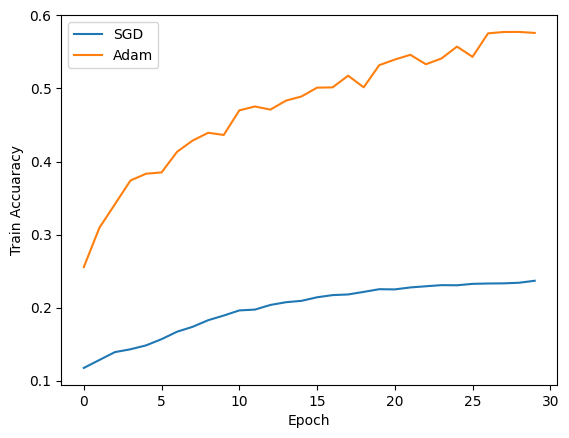

In [21]:
plot_acc(train_accs_sgd, train_accs_adam)

## (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교

In [25]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    ## 활성화 함수: sigmoid
    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [26]:
input_dim = 32 * 32 * 3
n_dim = 1024
lr = 0.001

model = Model(input_dim, n_dim).to('cuda')

n_epochs = 30
optimizer = SGD(model.parameters(), lr=lr)

In [27]:
train_accs_sig = []
test_accs_sig = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    ## CrossEntropy 정의
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # 1 epoch 당 정확도 저장
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  train_accs_sig.append(train_acc)
  test_accs_sig.append(test_acc)

  print(f"Epoch {epoch+1} | Loss: {total_loss} | Train Acc: {train_acc} | Test Acc: {test_acc}")

Epoch 1 | Loss: 452.05219197273254 | Train Acc: 0.1 | Test Acc: 0.1
Epoch 2 | Loss: 451.7280514240265 | Train Acc: 0.1 | Test Acc: 0.1
Epoch 3 | Loss: 451.533908367157 | Train Acc: 0.10006 | Test Acc: 0.1001
Epoch 4 | Loss: 451.4334788322449 | Train Acc: 0.10054 | Test Acc: 0.1004
Epoch 5 | Loss: 451.373929977417 | Train Acc: 0.10134 | Test Acc: 0.1008
Epoch 6 | Loss: 451.34152722358704 | Train Acc: 0.11932 | Test Acc: 0.1203
Epoch 7 | Loss: 451.3261933326721 | Train Acc: 0.11872 | Test Acc: 0.1209
Epoch 8 | Loss: 451.3164303302765 | Train Acc: 0.12102 | Test Acc: 0.1226
Epoch 9 | Loss: 451.3091266155243 | Train Acc: 0.1039 | Test Acc: 0.1038
Epoch 10 | Loss: 451.30492329597473 | Train Acc: 0.14432 | Test Acc: 0.1459
Epoch 11 | Loss: 451.30279183387756 | Train Acc: 0.12112 | Test Acc: 0.1203
Epoch 12 | Loss: 451.30027532577515 | Train Acc: 0.1126 | Test Acc: 0.1098
Epoch 13 | Loss: 451.29793524742126 | Train Acc: 0.1138 | Test Acc: 0.1125
Epoch 14 | Loss: 451.2955095767975 | Train Acc:

In [29]:
def plot_acc2(train_accs_leakyrelu, train_accs_sigmoid):
    x = np.arange(len(train_accs_leakyrelu))

    plt.plot(x, train_accs_leakyrelu, label='LeakyReLU')
    plt.plot(x, train_accs_sigmoid, label='Sigmoid')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.show()

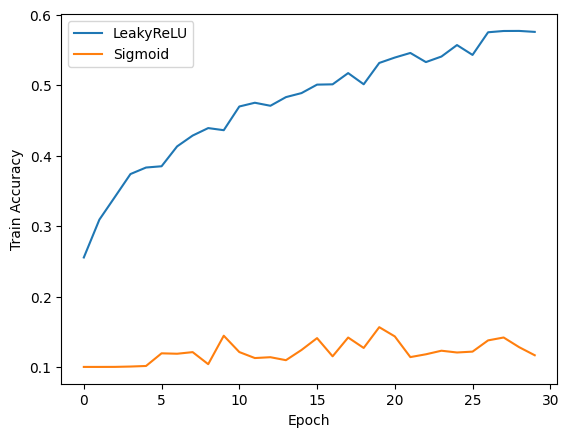

In [30]:
plot_acc2(train_accs_adam, train_accs_sig)

### (Plot 3) Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교

In [31]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Linear(input_dim, n_dim),
        nn.LeakyReLU(),
        nn.Dropout(0.1)
    )
    self.layer2 = nn.Sequential(
        nn.Linear(n_dim, n_dim),
        nn.LeakyReLU(),
        nn.Dropout(0.1)
    )
    self.layer3 = nn.Linear(n_dim, 10)

    ## 활성화 함수: LeakyReLU
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [32]:
input_dim = 32 * 32 * 3
n_dim = 1024
lr = 0.001

model = Model(input_dim, n_dim).to('cuda')

n_epochs = 30
optimizer = Adam(model.parameters(), lr=lr)

In [33]:
loss_fn = nn.CrossEntropyLoss()

train_accs_dropout = []
test_accs_dropout = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    ## CrossEntropy 정의
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)

  train_accs_dropout.append(train_acc)
  test_accs_dropout.append(test_acc)

  print(f"Epoch {epoch+1} | Loss: {total_loss} | Train Acc: {train_acc} | Test Acc: {test_acc}")

Epoch 1 | Loss: 437.70275139808655 | Train Acc: 0.18316 | Test Acc: 0.185
Epoch 2 | Loss: 400.0320336818695 | Train Acc: 0.27826 | Test Acc: 0.2764
Epoch 3 | Loss: 377.54629385471344 | Train Acc: 0.32184 | Test Acc: 0.3202
Epoch 4 | Loss: 363.0529919862747 | Train Acc: 0.345 | Test Acc: 0.3395
Epoch 5 | Loss: 351.6480984687805 | Train Acc: 0.3737 | Test Acc: 0.377
Epoch 6 | Loss: 341.3780837059021 | Train Acc: 0.38696 | Test Acc: 0.3934
Epoch 7 | Loss: 332.1821542978287 | Train Acc: 0.40108 | Test Acc: 0.4034
Epoch 8 | Loss: 324.69199085235596 | Train Acc: 0.41878 | Test Acc: 0.4195
Epoch 9 | Loss: 319.77724754810333 | Train Acc: 0.43228 | Test Acc: 0.4291
Epoch 10 | Loss: 312.80671298503876 | Train Acc: 0.44508 | Test Acc: 0.4417
Epoch 11 | Loss: 307.8382030725479 | Train Acc: 0.45874 | Test Acc: 0.4557
Epoch 12 | Loss: 301.92236483097076 | Train Acc: 0.45784 | Test Acc: 0.4475
Epoch 13 | Loss: 297.9824415445328 | Train Acc: 0.45456 | Test Acc: 0.4433
Epoch 14 | Loss: 294.192740321159

In [34]:
def plot_acc3(train_accs, test_accs):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label='Train Accuracy')
    plt.plot(x, test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

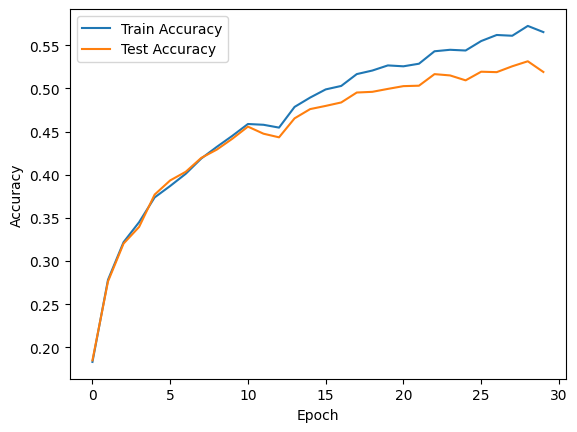

In [35]:
plot_acc3(train_accs_dropout, test_accs_dropout)